# Введение

### Моделируемый процесс:
$$y = w_0 + \bar w \cdot \bar x + \epsilon,\, \, \epsilon \backsim N(0, \sigma^2)$$
### Линейная регрессия:
$$\hat y = w_0 + \sum_{i = 1}^{N} w_i x_i = w_0 + \bar w \cdot \bar x$$
### Задача оптимизации:
**Обучающая выборка**: $\{\bar x_j, y_j\}_{j=1}^M$
$$E(w_0, \bar w) = \frac{1}{2M}\sum_{j=1}^{M}(w_0 + \bar w \cdot \bar x_j - y_j)^2 \rightarrow \min_{w_0, \bar w}$$
### Mean Squared Error:
$$MSE = \frac{1}{M}\sum_{j=1}^{M}(w_0 + \bar w \cdot \bar x_j - y_j)^2$$

In [86]:
import numpy as np

In [87]:
def generate_batches(X, y, batch_size):
    """Batches of size `batch_size` generator.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        The input data.
    
    y : ndarray, shape (n_samples,)
        The target values (real numbers).
    
    
    Returns
    -------
    Sequentially returning batches of size `batch_size`.
    """
    
    assert len(X) == len(y)
        
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    split_num = len(X)//batch_size
    
    for ind in np.split(perm[:split_num*batch_size], split_num):
        yield X[ind], y[ind]

class LinearRegression:
    """
    Ordinary least squares Linear Regression.
        
    LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
    to minimize the mean squared error(divided by 2 for convinient gradient calculation) 
    between the observed targets in the dataset, and the targets predicted by 
    the linear approximation.
        
    Parameters
    ----------
    fit_intercept : bool, default=True
        Whether to calculate the intercept for this model. If set
        to False, no intercept will be used in calculations
        (i.e. data is expected to be centered).
        
    Attributes
    ----------
    w : array of shape (n_features, )
        Estimated weights for the linear regression problem.
    mse_history : python list.
        History of mse score(to get an error fuction score, mse_history should be divided by 2).
    """
    
    def __init__(self, fit_intercept=True):
        self.w = None
        self.fit_intercept = fit_intercept
        self.mse_history = []
        
    def fit(self, X, y, method="GD", learning_rate="invscaling",
            eta0=0.01, power_t=0.25, epochs=1000, batch_size=30, 
            tol=1e-3, n_iter_no_change=5):
        """Fit linear regression model.
        
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features).
            Training data.
        
        y : array-like of shape (n_samples,)
            Target values (real numbers).
        
        method : {"norm_eq", "GD"}, defaul="GD"
            Fitting method.
          
            - "norm_eq" is a normal equations.
            
            - "GD" is a gradient decent.
        
        learning_rate : {"constant", "invscaling"}, default="invscaling"
            The learning rate schedule:
            
            - 'constant': `eta = eta0`
                
            - 'invscaling': `eta = eta0 / pow(t, power_t)`
            
            Only used if `method` is "GD".
        
        eta0 : double, default=0.01
            The initial learning rate for the 'constant', 'invscaling'
            schedules. The default value is 0.01.
        
        power_t : double, default=0.25
            The exponent for inverse scaling learning rate.
        
        epochs :int, default=1000
            The number of passes over the training data(aka max_iter).
            Only used if `method` is "GD".
        
        batch_size : int, defaul=30
            The number of samples for gradient calculation.
            For Full-Batch-GD put equal X.shape[0],
                Mini-Batch-GD put equal number in interval (1, X.shape[0]),
                Stochastic-GD put equal 1.
            Only used if `method` is "GD".
        
        
        tol : float, default=1e-3
            The stopping criterion. If it is not None, training will stop
            when (best_loss - loss < tol) for `n_iter_no_change` consecutive
            epochs.
            Only used if `method` is "GD".
        
        n_iter_no_change : int, default=5
            Number of iterations with no improvement to wait before early stopping.
            Only used if `method` is "GD".
        """
        
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        if method == "norm_eq":
            self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
            return self
        
        if self.w is None:
            self.w = np.random.randn(X.shape[1], 1)
        
        best_mse = np.inf
        t = 1
        iter_no_change = 0
        
        if learning_rate == "constant":
            power_t = 0
        
        for _ in range(epochs):
            for X_batch, y_batch in generate_batches(X, y, batch_size):
                eta = eta0/np.power(t, power_t)
                t += 1
                
                self.w -= eta*self.grad(X_batch, y_batch)
            
            mse = np.power(np.dot(X, self.w) - y,
                           2).sum()/X.shape[0]
            self.mse_history.append(mse)
            
            if tol is not None:
                iter_no_change = iter_no_change+1 if (best_mse-mse)<tol else 0
                
                if mse < best_mse: best_mse = mse
                if iter_no_change == n_iter_no_change: break
        
        return self
    
    def grad(self, X, y):
        return (np.dot((np.dot(X, self.w) - y).reshape(1, -1),
                       X)/X.shape[0]).reshape(-1, 1)
    
    def predict(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        
        return np.dot(X, self.w)

In [88]:
import pandas as pd
from time import time
from sklearn.metrics import mean_squared_error

In [89]:
def get_result_table(X_train, X_test, y_train, y_test, 
                     mini_batch_size=30, save_path=None, mse_round=2,
                     time_round=2, **kwargs):
    RES = pd.DataFrame(index=["Normal Eqs", "Full-Batch GD",
                              "Mini-Batch GD", "SGD"]) 
    time_col = [] # list of fitting-times in milliseconds(ms)
    
    tik = time()
    norm_eq_reg = LinearRegression().fit(X_train, y_train, method="norm_eq")
    time_col.append(np.round((time()-tik)*1e3, time_round))
    
    tik = time()
    full_batch_reg = LinearRegression().fit(X_train, y_train, 
                                            batch_size=X_train.shape[0], **kwargs)
    time_col.append(np.round((time()-tik)*1e3, time_round))
    
    tik = time()
    mini_batch_reg = LinearRegression().fit(X_train, y_train,
                                            batch_size=mini_batch_size, **kwargs)
    time_col.append(np.round((time()-tik)*1e3, time_round))
    
    tik = time()
    sgd_reg = LinearRegression().fit(X_train, y_train, batch_size=1, **kwargs)
    time_col.append(np.round((time()-tik)*1e3, time_round))
    
    RES["Test MSE"] = [np.round(mean_squared_error(y_test, mdl.predict(X_test)), mse_round)\
                       for mdl in [norm_eq_reg, full_batch_reg, mini_batch_reg, sgd_reg]]
    RES["Train MSE"] = [np.round(mean_squared_error(y_train, mdl.predict(X_train)), mse_round)\
                        for mdl in [norm_eq_reg, full_batch_reg, mini_batch_reg, sgd_reg]]
    RES["Fit-Time(ms)"] = time_col
    RES["Epochs"] = [len(mdl.mse_history) for mdl in\
                     [norm_eq_reg, full_batch_reg, mini_batch_reg, sgd_reg]]
    
    if save_path is not None:
        RES.to_excel(save_path)
    
    return RES

# Пример

### Моделируемый процесс:
$$y = 4.0 + 0.8x$$

In [98]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [99]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = 4.0 + 0.8*X + np.random.randn(X.shape[0], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [107]:
get_result_table(X_train, X_test, y_train, y_test, save_path="results.xlsx")

Test MSE  Train MSE  Fit-Time(ms)  Epochs
Normal Eqs         0.58       0.76          0.72       0
Full-Batch GD      0.65       1.02         77.35     764
Mini-Batch GD      0.57       0.89         68.30     536
SGD                0.59       0.76         84.42      38

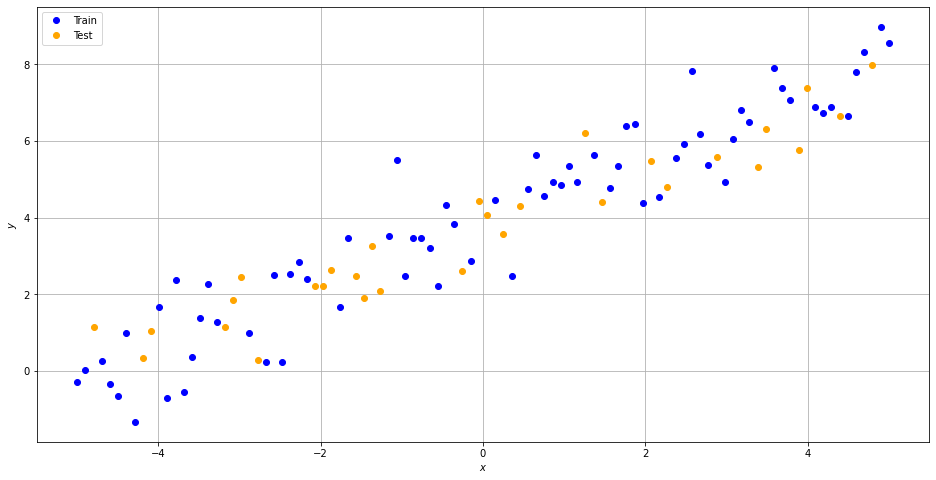

In [101]:
# Graph of Sample
plt.figure(figsize=(16, 8))

plt.plot(X_train, y_train, "o", color="blue", label="Train")
plt.plot(X_test, y_test, "o", color="orange", label="Test")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True)
plt.legend()

plt.show()

In [102]:
# Train Models via SGD and Normal Eqs.
norm_eq_reg = LinearRegression().fit(X_train, y_train, method="norm_eq")
sgd_reg = LinearRegression().fit(X_train, y_train, batch_size=1)

y_norm_eq_pred = norm_eq_reg.predict(X_test)
y_sgd_pred = sgd_reg.predict(X_test)

In [103]:
# Weights (exact: [4.0, 0.8])
norm_eq_reg.w, sgd_reg.w

(array([[3.92201219],
        [0.83974199]]),
 array([[3.88002094],
        [0.83651214]]))

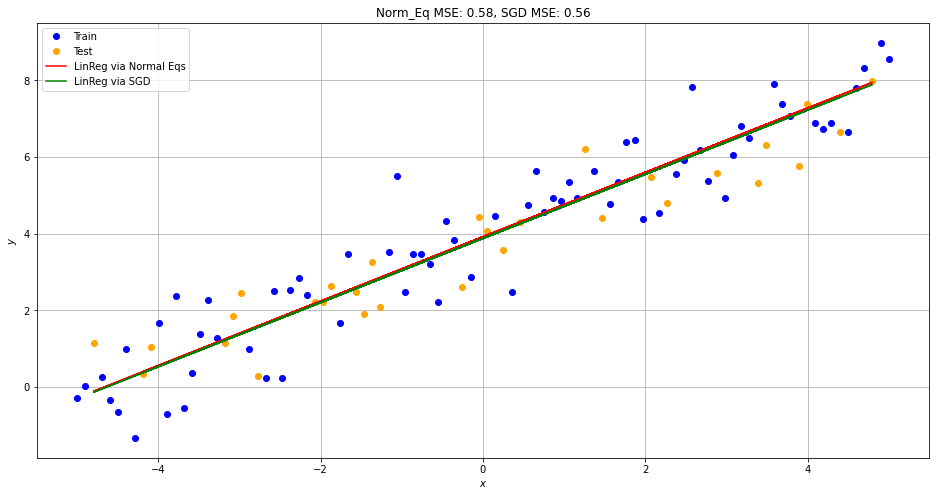

In [104]:
from sklearn.metrics import mean_squared_error

norm_eq_reg_mse = np.round(mean_squared_error(y_test, y_norm_eq_pred), 2)
sgd_reg_mse = np.round(mean_squared_error(y_test, y_sgd_pred), 2)

# Graph of predictions
plt.figure(figsize=(16, 8))

plt.plot(X_train, y_train, "o", color="blue", label="Train")
plt.plot(X_test, y_test, "o", color="orange", label="Test")
plt.plot(X_test, y_norm_eq_pred, color="red", label="LinReg via Normal Eqs")
plt.plot(X_test, y_sgd_pred, color="green", label="LinReg via SGD")

plt.title("Norm_Eq MSE: {}, SGD MSE: {}".format(norm_eq_reg_mse, sgd_reg_mse))
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.grid(True)
plt.legend()

plt.show()

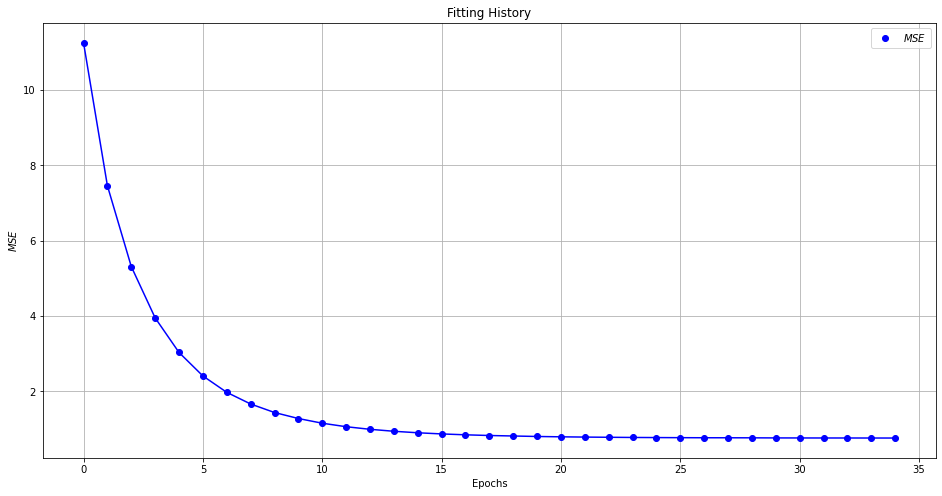

In [105]:
# LinReg via SGD - MSE vs Epochs graph
plt.figure(figsize=(16, 8))

plt.plot(sgd_reg.mse_history, "o", color="blue", label="$MSE$")
plt.plot(sgd_reg.mse_history, color="blue")

plt.title("Fitting History")
plt.xlabel("Epochs")
plt.ylabel("$MSE$")

plt.grid(True)
plt.legend()

plt.show()